In [1]:
%matplotlib inline
import numpy as np
import sklearn.datasets as data
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb; sb.set_style( 'darkgrid' ) # use whitegrid if prefer a white background
import pandas as pd

from numpy.random import SeedSequence, default_rng
rng = default_rng( SeedSequence().entropy )

import warnings
warnings.filterwarnings("ignore")

#matplotlib.rcParams.update( { 'font.size': 18 } ) # Use this to setup your preferred font size for plotting

#### 1- First estimate different covariances on the Iris dataset using Gaussian Mixture Models. Plot the different covriance estimation and how well they fit to the data with different number of components and iterations.

+ Bonus: use np.random.norma( mu, sigma, X.shape ) and see how noise affects the estimations

In [2]:
from sklearn.model_selection import train_test_split
from fml5_helper_funcs import make_ellipses
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
X, Y = data.load_iris( return_X_y = True )

Xtrain, Xtest, ytrain, ytest = train_test_split( X, Y, 
                                                 test_size = 0.3,
                                                 random_state = rng.integers( 4231 ) 
                                               )

In [4]:
# Experiment with different number of components in the Gaussian Mixture
# model and different amount of iterations

GMMs = {cov_type: GaussianMixture( n_components    = 3       ,
                                   covariance_type = cov_type, 
                                   max_iter        =20       ,
                                   random_state = rng.integers( 212 )
                                 )
              for cov_type in ['spherical', 'diag', 'tied', 'full']
       }

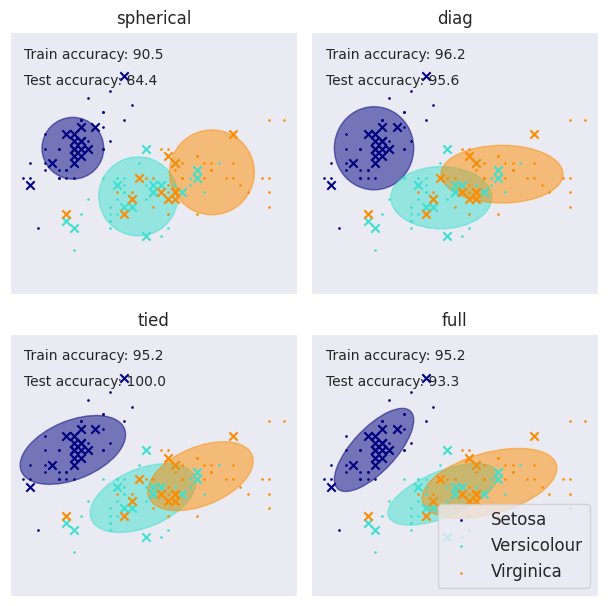

In [5]:
n_classes    = 3
n_estimators = len( GMMs )
ynames = [ 'Setosa', 'Versicolour', 'Virginica']
colors = ['navy', 'turquoise', 'darkorange']

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, ( name, estimator ) in enumerate(GMMs.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([Xtrain[ytrain == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(Xtrain)
    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h, colors )

    for n, color in enumerate(colors):
        data = X[ Y == n ]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=ynames[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = Xtest[ytest == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(Xtrain)
    train_accuracy = np.mean(y_train_pred.ravel() == ytrain.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(Xtest)
    test_accuracy = np.mean(y_test_pred.ravel() == ytest.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

#### 2- Perform K-means clustering on the Iris dataset. Try adding Gaussian noise, different $\mu$ and $\sigma$, to the observations and see how the noise and covariance structure of the data affects the computing of the clusters. How does this compare to the Gaussian Mixture Model?

For n_clusters = 2 The average silhouette_score is : 0.6810461692117462
For n_clusters = 3 The average silhouette_score is : 0.5528190123564095
For n_clusters = 4 The average silhouette_score is : 0.49805050499728737
For n_clusters = 5 The average silhouette_score is : 0.48874888709310566
For n_clusters = 6 The average silhouette_score is : 0.36784649847122436


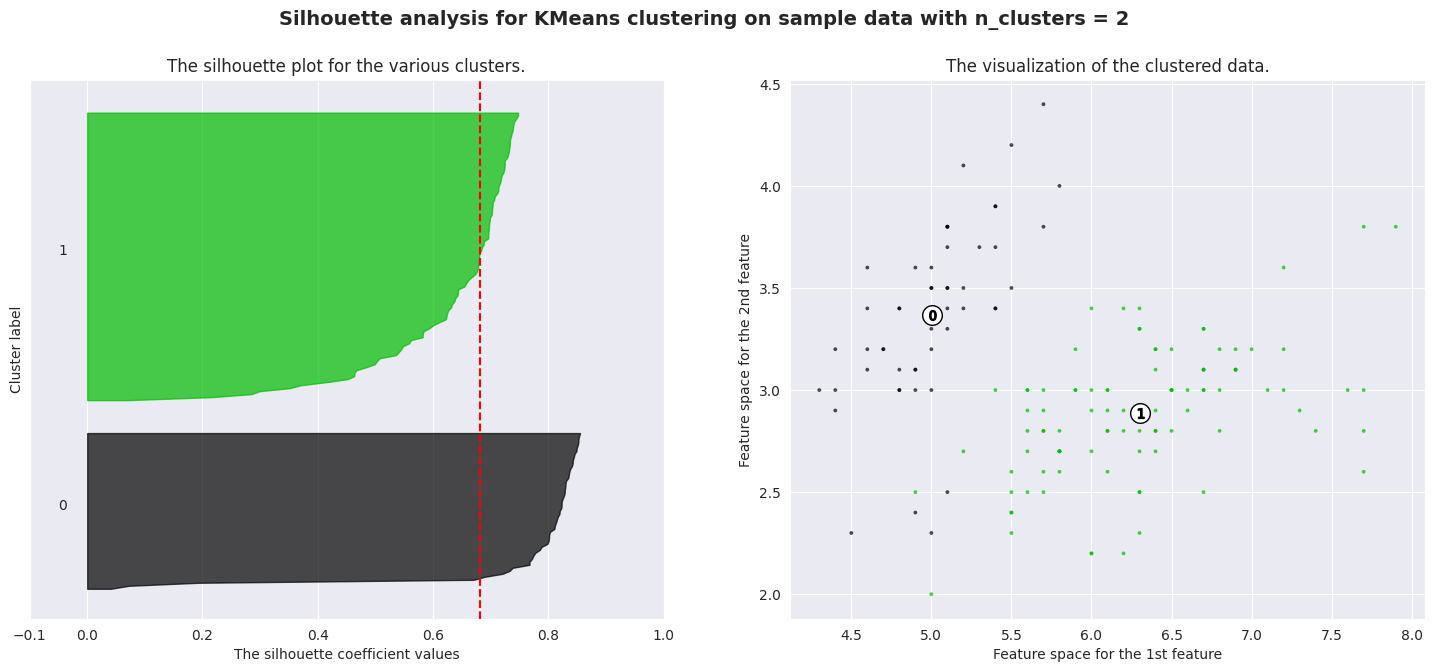

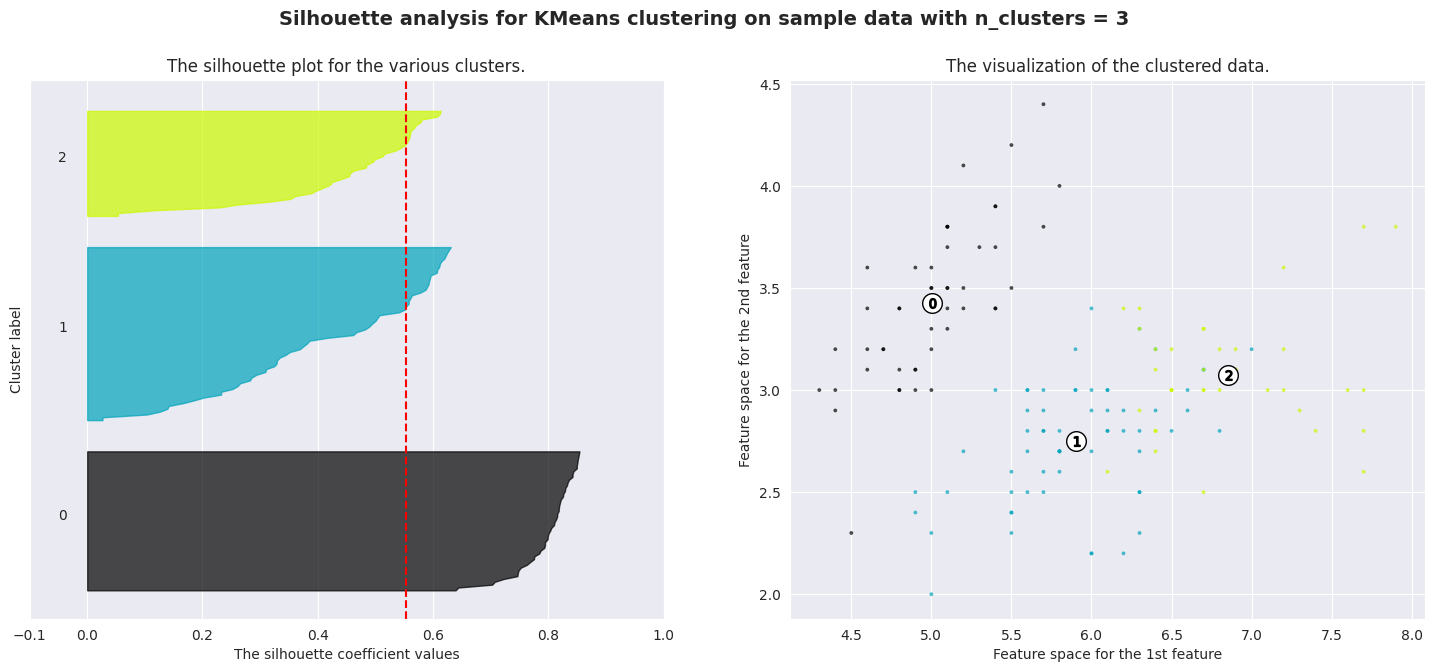

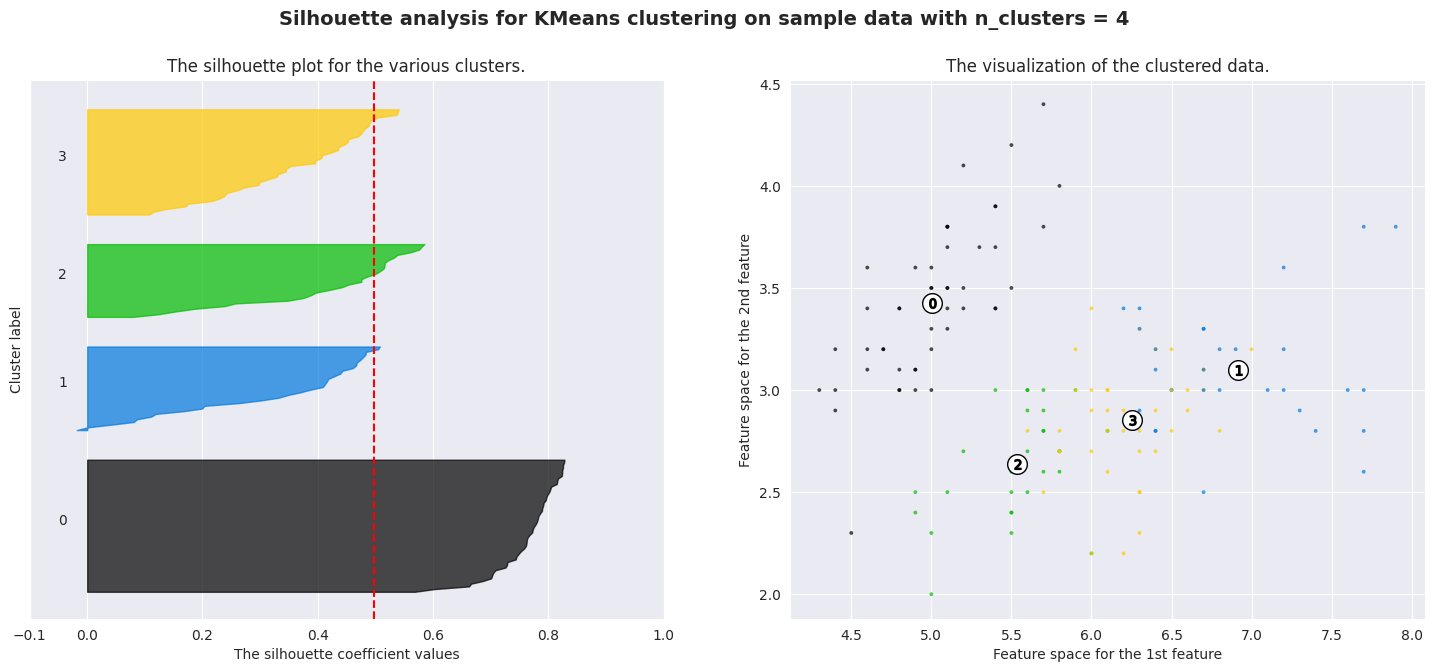

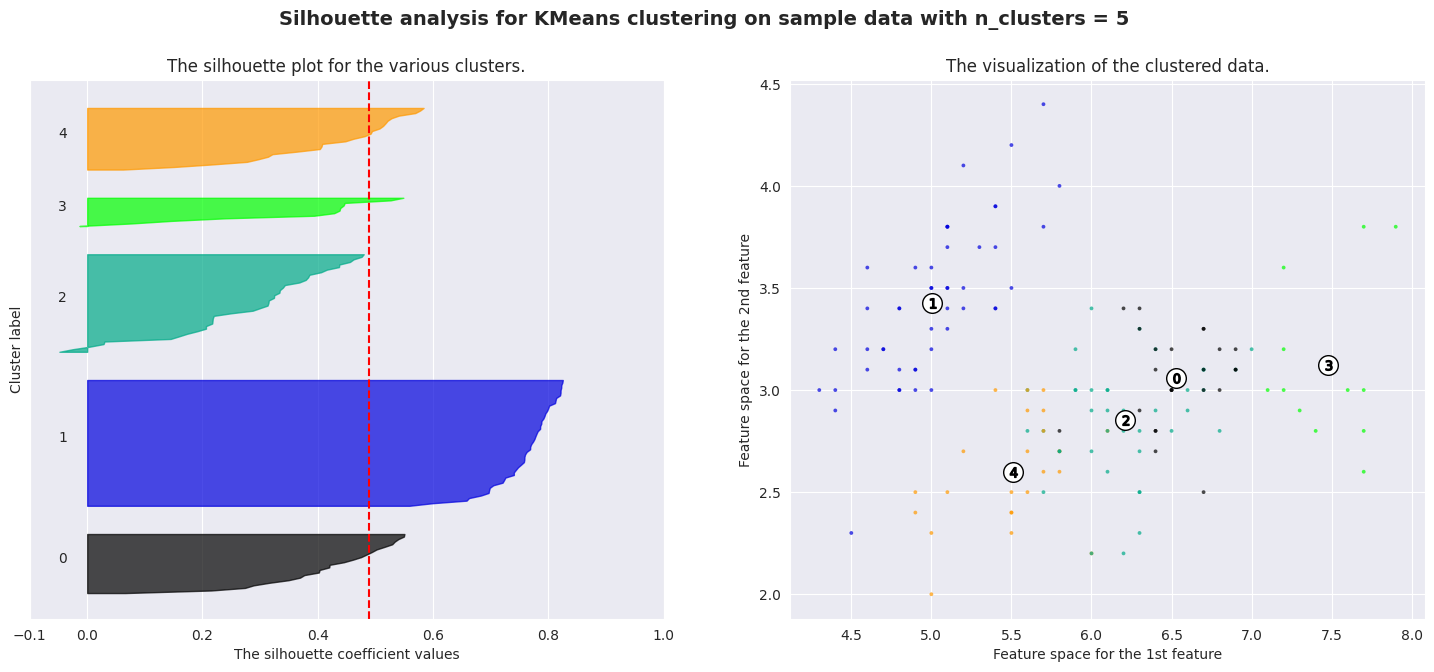

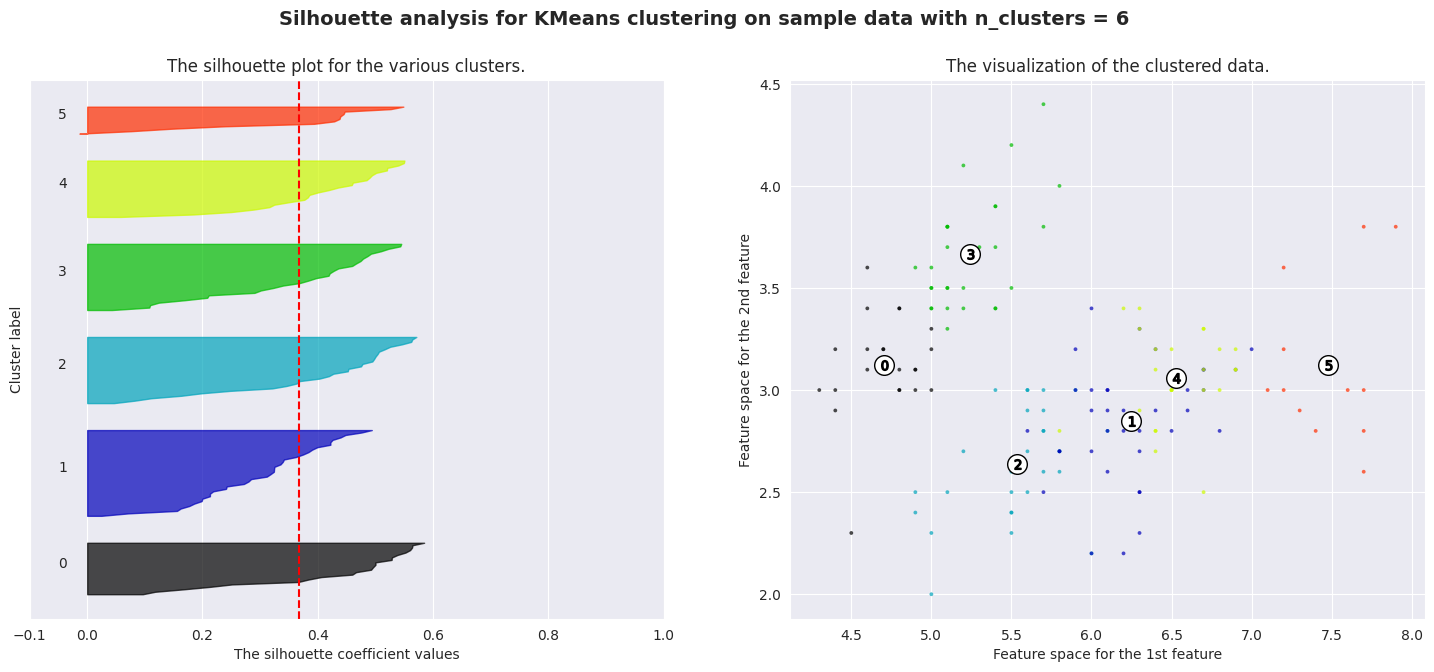

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer      = KMeans(n_clusters=n_clusters, random_state = rng.integers( 2415 ) )
    X              = X + np.random.normal( 0, 1, X.shape )
    cluster_labels = clusterer.fit_predict( X )

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score( X, cluster_labels )
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range( n_clusters ):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed. See how the clusters look from different feature columns
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

#### 3- Use Hierachical clustering to segment coins from a image. Use different numbers of clusters and see which affinity and linkage combination gives the best result

Compute structured hierarchical clustering...
Elapsed time: 0.223s
Number of pixels: 4697
Number of clusters: 30


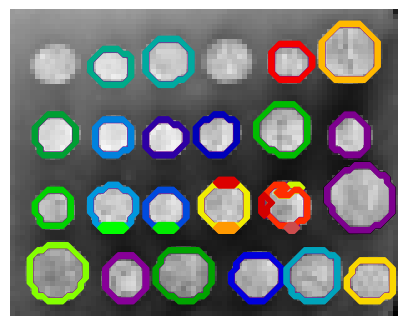

In [34]:
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale

from skimage.data import coins

orig_coins = coins()
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(
    smoothened_coins,
    0.2,
    mode="reflect",
    anti_aliasing=False,
)

Xd = np.reshape(rescaled_coins, (-1, 1))

from sklearn.feature_extraction.image import grid_to_graph

connectivity = grid_to_graph(*rescaled_coins.shape)

import time as time

from sklearn.cluster import AgglomerativeClustering

print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 30  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, affinity = 'l2', linkage="complete", connectivity=connectivity
)
ward.fit(Xd)
label = np.reshape(ward.labels_, rescaled_coins.shape)
print(f"Elapsed time: {time.time() - st:.3f}s")
print(f"Number of pixels: {label.size}")
print(f"Number of clusters: {np.unique(label).size}")


plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(
        label == l,
        colors=[
            plt.cm.nipy_spectral(l / float(n_clusters)),
        ],
    )
plt.axis("off")
plt.show()

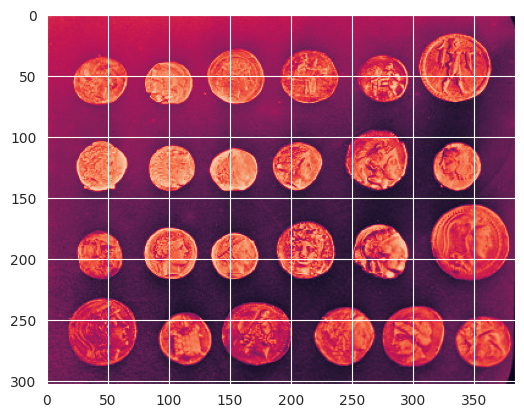

In [28]:
plt.imshow( orig_coins )